In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random
import argparse
import json
from torch.backends import cudnn
from tensorboardX import SummaryWriter
import pandas as pd
import time
import torchvision.utils as vutils  # Import vutils
import matplotlib.pyplot as plt

# from networks.Generator import Generator
# from networks.Discriminator import Discriminator
# from dataProcess.data_loader import getProperLoader
# from trains.train import train

## DataLoader

In [2]:
class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)


    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        df = pd.read_csv(self.attr_path)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        all_attr_names = df.columns
        for i, attr_name in enumerate(all_attr_names[1:]):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name
            
        for i, row in df.iterrows(): #Iterating over all the rows of dataset
            filename = row.iloc[0]  # Assuming the first column is the filename
            values = row.iloc[1:]   # The remaining columns are the attributes
            label = []
            # selected_attrs: (like) ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]        
                if idx >= len(values):
                    raise IndexError(f"Index {idx} is out-of-bounds for values with length {len(values)}.")
                label.append(values.iloc[idx] == 1) # [0,0,0,0,0,1]
#             print(label)
            # Append to test or train dataset based on the row index
            if (i+1) < 2000:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])
        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, selected_attrs, crop_size=178, image_size=128,
               batch_size=16, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, selected_attrs, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

def getProperLoader(config):
    # Data loader.
    celeba_loader = None
    rafd_loader = None
    # Data loader.
    if config.dataset in ['CelebA', 'Both']:
        celeba_loader = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)
    if config.dataset in ['RaFD', 'Both']:
        rafd_loader = get_loader(config.rafd_image_dir, None, None,
                                 config.rafd_crop_size, config.image_size, config.batch_size,
                                 'RaFD', config.mode, config.num_workers)
    data_loader = celeba_loader if config.dataset == 'CelebA' else rafd_loader if config.dataset == 'RaFD' else None
    assert data_loader is not None, "data_loader is not properly set."
    return data_loader

## Model

In [3]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)


class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        """
        For skip input of label c, c should be original label, not already tiled (which disable c input for shrinked/expanded layers)
        """
        # Replicate spatially and concatenate domain information.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

In [4]:
class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)

    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

## Train function

In [5]:
def label2onehot(labels, dim):
    """Convert label indices to one-hot vectors."""
    batch_size = labels.size(0)
    out = torch.zeros(batch_size, dim)
    out[np.arange(batch_size), labels.long()] = 1
    return out


def classification_loss(logit, target, dataset='CelebA'):
    """Compute binary or softmax cross entropy loss."""
    if dataset == 'CelebA':
        return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
    elif dataset == 'RaFD':
        return F.cross_entropy(logit, target)


def train(config, G, D, g_optimizer, d_optimizer, data_loader, device, writer):
    """Train StarGAN within a single dataset."""
    # Learning rate cache for decaying.
    g_lr = config.g_lr
    d_lr = config.d_lr

    # Start training.
    print('Start training...')
    start_time = time.time()
    start_iters = 0
    data_iter = iter(data_loader)
    for i in range(start_iters, config.num_iters):
        # single iteration
        ####### 1. Preprocess input data
        # Fetch real images and labels.
        x_real, label_org = next(data_iter)

        # Generate target domain labels randomly.
        rand_idx = torch.randperm(label_org.size(0))
        label_trg = label_org[rand_idx]

        #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        if config.dataset == 'CelebA':
            c_org = label_org.clone()
            c_trg = label_trg.clone()
        elif config.dataset == 'RaFD':
            c_org = label2onehot(label_org, config.c_dim)
            c_trg = label2onehot(label_trg, config.c_dim)
        #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        x_real = x_real.to(device)           # Input images.
        c_org = c_org.to(device)             # Original domain labels.
        c_trg = c_trg.to(device)             # Target domain labels.
        label_org = label_org.to(device)     # Labels for computing classification loss.
        label_trg = label_trg.to(device)     # Labels for computing classification loss.

        ####### 2. Train the discriminator

        # Compute loss with real images.
        out_src, out_cls = D(x_real)
        # mean of 2D probability patch
        d_loss_real = - torch.mean(out_src)
        d_loss_cls = classification_loss(out_cls, label_org, config.dataset)

        # Compute loss with fake images.
        x_fake = G(x_real, c_trg)
        out_src, out_cls = D(x_fake.detach())
        d_loss_fake = torch.mean(out_src)

        # Compute loss for gradient penalty.
        alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
        x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
        out_src, _ = D(x_hat)
        d_loss_gp = gradient_penalty(out_src, x_hat, device)

        # Backward and optimize.
        d_loss = d_loss_real + d_loss_fake + config.lambda_cls * d_loss_cls + config.lambda_gp * d_loss_gp
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()

        loss = {}
        loss['D/adv_real'] = d_loss_real.item()
        loss['D/adv_fake'] = d_loss_fake.item()
        loss['D/cls'] = d_loss_cls.item()
        loss['D/gp'] = d_loss_gp.item()
        ########  3. Train the generator

        # 1 Generator training per n_critic Discriminator training
        if (i+1) % config.n_critic == 0:
            # Original-to-target domain.
            x_fake = G(x_real, c_trg)
            out_src, out_cls = D(x_fake)
            g_loss_fake = - torch.mean(out_src)
            g_loss_cls = classification_loss(out_cls, label_trg, config.dataset)

            # Target-to-original domain.
            x_reconst = G(x_fake, c_org)
            g_loss_rec = torch.mean(torch.abs(x_real - x_reconst)) # L1 loss

            # Backward and optimize.
            g_loss = g_loss_fake + config.lambda_rec * g_loss_rec + config.lambda_cls * g_loss_cls
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            loss['G/adv'] = g_loss_fake.item()
            loss['G/rec'] = g_loss_rec.item()
            loss['G/cls'] = g_loss_cls.item()
        # =================================================================================== #
        #                               4. After                                              #
        # =================================================================================== #

        # Decay learning rates.
        if (i+1) % config.lr_update_step == 0 and (i+1) > (config.num_iters - config.num_iters_decay):
            g_lr -= (config.g_lr / float(config.num_iters_decay))
            d_lr -= (config.d_lr / float(config.num_iters_decay))
            # """Decay learning rates of the generator and discriminator."""
            for param_group in g_optimizer.param_groups:
                param_group['lr'] = g_lr
            for param_group in d_optimizer.param_groups:
                param_group['lr'] = d_lr

        if (i+1) % config.log_step == 0:
            for tag, value in loss.items():
                writer.add_scalar(tag, value, i+1)

def gradient_penalty(y, x, device):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

## Actual Training

In [6]:
import argparse
import json
import os
import torch
from torch.utils.tensorboard import SummaryWriter


class Cfg:
    pass


def importAndProcessConfigs(parser, config_file="NNconfig.json"):
    # Load configurations from the JSON file
    with open(config_file, "r") as f:
        argSettings = json.load(f)

    # Get the existing arguments to avoid re-adding them
    existing_args = {action.dest for action in parser._actions}

    for setting in argSettings:
        arg_name = setting.pop("name")

        # Only add the argument if it hasn't been provided in the command line
        if arg_name not in existing_args:
            posArgs = ["--" + arg_name]
            if "list" in setting:
                setting.pop("list")
                posArgs.append("--list")

            # Convert type
            if "type" in setting:
                setting["type"] = int if setting["type"] == "int" else float if setting["type"] == "float" else str
            if "default" in setting and setting["default"] == "None":
                setting["default"] = None

            parser.add_argument(*posArgs, **setting)


def loadConfig(config_file="NNconfig.json"):
    with open(config_file, "r") as f:
        argSettings = json.load(f)
    
    cfg = Cfg()
    for setting in argSettings:
        if "default" in setting and setting["default"] == "None":
            setting["default"] = None
        setattr(cfg, setting["name"], setting["default"])
    return cfg


def prepareDirs(config):
    # Create directories if not exist.
    dirs = [config.log_dir, config.model_save_dir, config.sample_dir, config.result_dir]
    for directory in dirs:
        if not os.path.exists(directory):
            os.makedirs(directory)

def load_checkpoint(config, G, D, g_optimizer, d_optimizer, device):
    start_iter = 0

    if config.checkpoint_load_dir and os.path.exists(config.checkpoint_load_dir):
        checkpoint = torch.load(config.checkpoint_load_dir, map_location=device)
        G.load_state_dict(checkpoint['model_G_state_dict'])
        D.load_state_dict(checkpoint['model_D_state_dict'])
        
        # Load optimizers' state dict
        g_optimizer.load_state_dict(checkpoint['optimizer_G_state_dict'])
        d_optimizer.load_state_dict(checkpoint['optimizer_D_state_dict'])
        
        # Load iteration
        start_iter = checkpoint['iteration']
        print(f"Checkpoint loaded: starting from iteration {start_iter}")
    else:
        print("No checkpoint found. Starting from scratch.")

    return G, D, g_optimizer, d_optimizer, start_iter


def main(config):
    # For fast training.
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Running preparation
    prepareDirs(config)
    writer = SummaryWriter(config.log_dir)

    # Data preparation
    # data_loader = getProperLoader(config)

    # Model Initialization
    G = Generator(config.g_conv_dim, config.c_dim, config.g_repeat_num)
    D = Discriminator(config.image_size, config.d_conv_dim, config.c_dim, config.d_repeat_num)
    g_optimizer = torch.optim.Adam(G.parameters(), config.g_lr, [config.beta1, config.beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), config.d_lr, [config.beta1, config.beta2])
    G.to(device)
    D.to(device)
    
    G, D, g_optimizer, d_optimizer, start_iter = load_checkpoint(config, G, D, g_optimizer, d_optimizer, device)

    # If no checkpoint was found, start_iter will be 0
    iters = max(start_iter, 0)

    print(f'Starting from iteration {iters}')

    # Training/Test
    # if config.mode == 'train':
    #     train(config, G, D, g_optimizer, d_optimizer, data_loader, device, writer)
    # elif config.mode == 'test':
    #     test(config, G, data_loader, device)
    return G


# Argument parser setup
parser = argparse.ArgumentParser()

parser.add_argument('--mode', type=str, default=None, help='Mode (train/test)')
parser.add_argument('--dataset', type=str, default=None, help='Dataset name')
parser.add_argument('--image_size', type=int, default=None, help='Image size')
parser.add_argument('--c_dim', type=int, default=None, help='Number of classes/attributes')
parser.add_argument('--sample_dir', type=str, default=None, help='Directory to save samples')
parser.add_argument('--log_dir', type=str, default=None, help='Directory to save logs')
parser.add_argument('--model_save_dir', type=str, default=None, help='Directory to save models')
parser.add_argument('--result_dir', type=str, default=None, help='Directory to save results')
parser.add_argument('--selected_attrs', nargs='+', default=None, help='List of selected attributes')
parser.add_argument('--celeba_image_dir', type=str, default=None, help='Celeb Images Path')
parser.add_argument('--attr_path', type=str, default=None, help='Celeb Attribute file path')
parser.add_argument('--num_workers', type=int, default=None, help='Workers for data loader')
parser.add_argument('--checkpoint_load_dir', type=str, default=None, help='Checkpoint load directory')
parser.add_argument('--checkpoint_save_dir', type=str, default=None, help='Checkpoint save directory')



# Parse initial arguments (for testing purposes)
args, unknown = parser.parse_known_args([
    '--mode', 'train',
    '--dataset', 'CelebA',
    '--image_size', '128',
    '--c_dim', '5',
    '--sample_dir', 'trial1/samples',
    '--log_dir', 'trial1/logs',
    '--model_save_dir', 'trial1/models',
    '--result_dir', 'trial1/results',
    '--selected_attrs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young',
    '--celeba_image_dir', 'data/img_align_celeba',
    '--attr_path', 'data/list_attr_celeba.csv',
    '--num_workers', '0',
    '--checkpoint_load_dir', 'checkpoints/checkpoint.pth',
    '--checkpoint_save_dir', 'checkpoints',
])

# Load JSON configuration into config object
config_json = loadConfig()

# Import and process additional arguments from JSON configuration
importAndProcessConfigs(parser)

# Override JSON configurations with command-line arguments if provided
for key, value in vars(args).items():
    if value is not None:
        setattr(config_json, key, value)

# Final configuration object
config = config_json

# Run the main function with the final configuration
G = main(config)
# print(vars(config))



Checkpoint loaded: starting from iteration 120000
Starting from iteration 120000


In [7]:
data_loader = getProperLoader(config)

Finished preprocessing the CelebA dataset...


In [8]:
data_iter = iter(data_loader)
x_real, label_org = next(data_iter)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = config.c_dim  # Assuming c_dim is the number of one-hot labels

In [30]:
checkpoint_dir = "saved_model/checkpoint_c6.pth"
# G2 = Generator()
G2 = Generator(config.g_conv_dim, 6, config.g_repeat_num)
num_labels = 6

if checkpoint_dir and os.path.exists(checkpoint_dir):
    checkpoint = torch.load(checkpoint_dir, map_location=torch.device('cpu'))
    G2.load_state_dict(checkpoint['model_G_state_dict'])
    print("Checkpoint loaded successfully.")
else:
    print("No checkpoint found for model.")

# G2.eval()  # Set the model to evaluation mode

Checkpoint loaded successfully.


In [40]:
input_img = Image.open('test5.jpg')
print(input_img.size)
# image_array = np.array(input_img)

crop_size = 178
image_size = 128

transform = []
if(input_img.size[0]!=178 or input_img.size[1]!=218):
    transform.append(T.Resize((218, 178)))
    
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)
x_real = transform(input_img)
x_real = x_real.unsqueeze(0)

(2179, 2283)


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


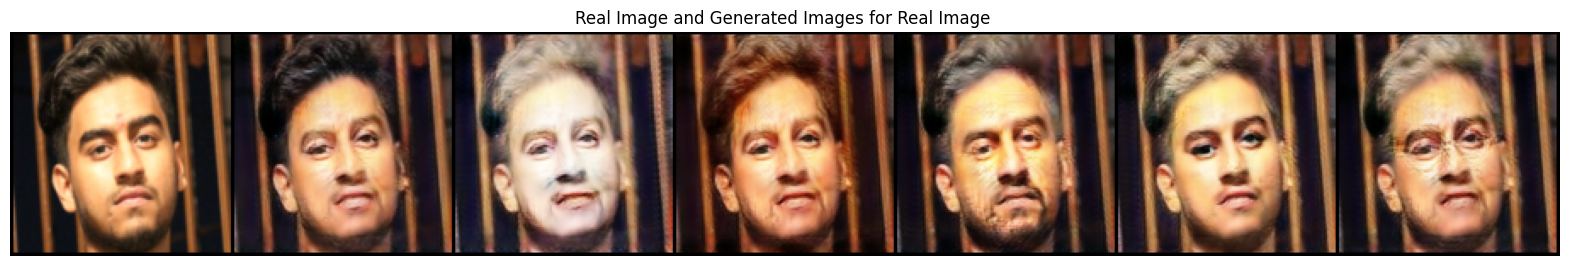

In [41]:
all_images = []
generated_images = []
# Generate images for each possible one-hot label
for k in range(num_labels):
    # Create one-hot label for the k-th class
    one_hot_label = torch.zeros((1, num_labels))
    one_hot_label[0, k] = 1

    # Generate the image
    with torch.no_grad():
        fake_image = G2(x_real[0].unsqueeze(0), one_hot_label).detach().cpu()
    print(fake_image.shape)

    generated_images.append(fake_image.squeeze(0))
print(x_real.shape)

# Combine the real image with generated images into a single list
all_images = [x_real[0]] + generated_images

# Create a grid of all images
all_images_grid = vutils.make_grid(all_images, nrow=num_labels + 1, normalize=True, scale_each=True)

# Plot the combined grid
plt.figure(figsize=(20, 5))
plt.imshow(np.transpose(all_images_grid.numpy(), (1, 2, 0)))
plt.title(f'Real Image and Generated Images for Real Image ')
plt.axis('off')
plt.show()

In [117]:
# input_img = Image.open('000042.jpg')
# input_img = Image.open('000043.jpg')
# input_img = Image.open('test.jpg')
# input_img = Image.open('test2.jpg')
# input_img = Image.open('test3.jpg')
input_img = Image.open('test4.jpg')
input_img = Image.open('johnwick.jpg')
print(input_img.size)
print(input_img.size[0])
# input_img

(4051, 4051)
4051


torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])


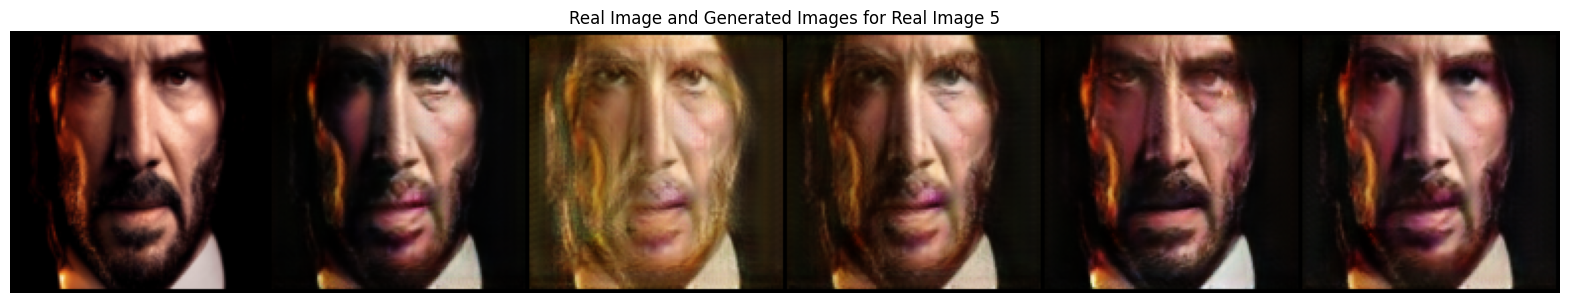

In [118]:
crop_size=178
image_size=128
transform = []
if(input_img.size[0]!=178 or input_img.size[1]!=218):
    transform.append(T.Resize((218, 178)))
transform.append(T.CenterCrop(crop_size))
transform.append(T.Resize(image_size))
transform.append(T.ToTensor())
transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
transform = T.Compose(transform)

image = transform(input_img)
print(image.shape)
all_images = []
generated_images = []
for k in range(num_labels):
    # Create one-hot label for the k-th class
    one_hot_label = torch.zeros((1, num_labels)).to(device)
    one_hot_label[0, k] = 1

    # Generate the image
    with torch.no_grad():
        fake_image = G(image.unsqueeze(0).to(device), one_hot_label).detach().cpu()
    print(fake_image.shape)

    generated_images.append(fake_image.squeeze(0))

all_images = [image] + generated_images

# Create a grid of all images
all_images_grid = vutils.make_grid(all_images, nrow=num_labels + 1, normalize=True, scale_each=True)\

print(image.shape)
plt.figure(figsize=(20, 5))
plt.imshow(np.transpose(all_images_grid.numpy(), (1, 2, 0)))
plt.title(f'Real Image and Generated Images for Real Image {j + 1}')
plt.axis('off')
plt.show()